# Product Category Classification

The objective of this notebook is to build a Product Category Classification model using 
the product descriptions and features provided, and show a brief walk through over the modeling process and decisions. 
The notebook is separated into the following sections:
* EDA (Exploratory Data Analysis)
* Data Processing
* Modeling
* Model Analysis
* Improvements

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os

In [77]:
datadir = './data/'
savedir = './results/'

dataset = pd.read_csv(os.path.join(datadir, 'testset_C.csv'), sep=';')

# create labels
encoder = LabelEncoder()
encoder.fit(dataset['productgroup'])
dataset['class'] = encoder.transform(dataset['productgroup'])

## EDA

In this section, we explore the dataset and get a better understanding of the features.

In [3]:
# Establish rules for dataset
dataset.head()

,id,productgroup,main_text,add_text,manufacturer,class
0,26229701,WASHINGMACHINES,WAQ284E25,WASCHMASCHINEN,BOSCH,3
1,16576864,USB MEMORY,LEEF IBRIDGE MOBILE SPEICHERERWEITERUNG FUER I...,PC__1100COMPUTINGMEMORY__1110MEMORYCARDS,LEEF,2
2,26155618,USB MEMORY,SANDISK 32GB ULTRA FIT USB 3.0,W1370,NaN,2
3,25646138,BICYCLES,HOLLANDRAD DAMEN 28 ZOLL TUSSAUD 3-GAENGE RH 5...,FAHRRAEDER // SPORTFAHRRAEDER,SCHALOW & KROH GMBH,0
4,19764614,BICYCLES,DAHON SPEED D7 SCHWARZ ? FALTRAD,SPORTS__30000WHEELED__30070BIKES,DAHON,0


#### Product Category

The plot indicates that the dataset is balanced and all categories have enough samples.

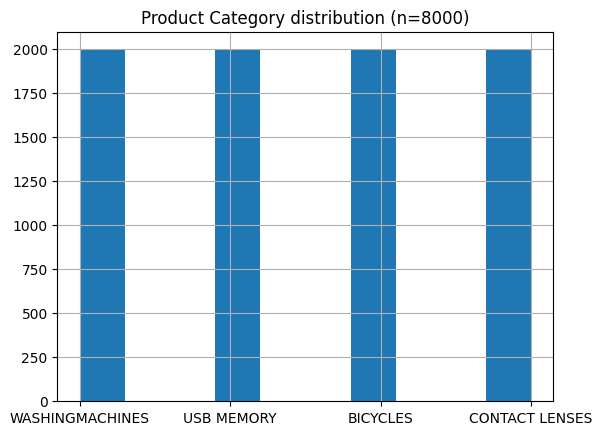

In [4]:
dataset.productgroup.hist()
plt.title(f'Product Category distribution (n={len(dataset)})')
plt.show()

#### Manufacturers

There is only a finite number of manufacturers in the dataset, and since these are product categories, it is quite likely that the category can be identified by using just the manufacturers alone. 

(But that solution can be trivial and does not generalize, so we will not do that)

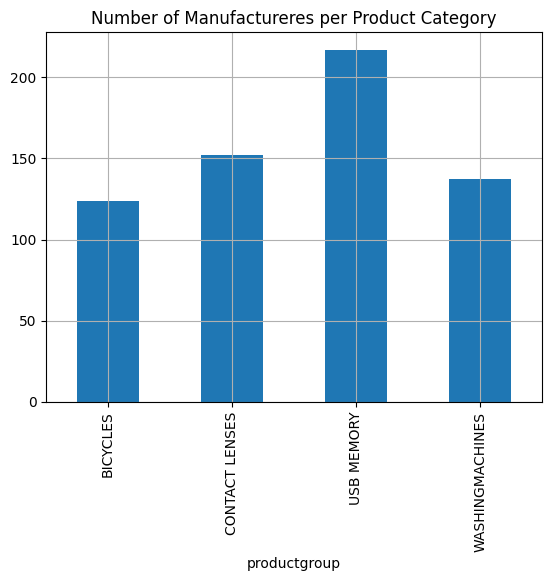

In [35]:
dataset.groupby('productgroup')['manufacturer'].nunique().plot.bar()
plt.grid()
plt.title('Number of Manufactureres per Product Category')
plt.show()

#### Descriptions

`main_text`
* Feature seems to be the most informative. But also has long-form text.
* However, most categories are identifiable from within the 1st 20-30 tokens.
* When this feature is extremely short, combining this with other features
    makes it easier to identify the category

`add_text`
* Though it does not have enough text (mostly 1 word or less), it has
    directly relevant text description when it is not just numbers

In [5]:
# how is the description? - most products can be identified by 1st 20 characters
dataset.main_text.str.split(' ').str.len().describe()

count    7998.000000
mean        7.850713
std         7.232900
min         1.000000
25%         5.000000
50%         6.000000
75%         9.000000
max       220.000000
Name: main_text, dtype: float64

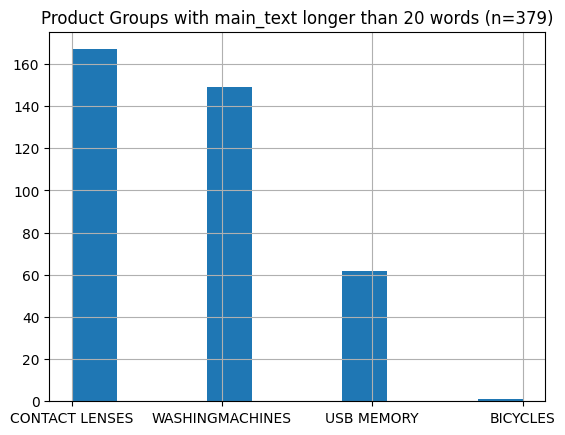

In [6]:
# which categories have the longest descriptions
tmp = dataset.productgroup[dataset.main_text.str.split(' ').str.len() > 20]
tmp.hist()
plt.title(f'Product Groups with main_text longer than 20 words (n={len(tmp)})')
plt.show()

In [7]:
# how is the additional description
dataset.add_text.str.split(' ').str.len().describe()

count    8000.000000
mean        1.653125
std         1.485119
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        10.000000
Name: add_text, dtype: float64

In [8]:
dataset.loc[dataset.main_text.str.split(' ').str.len() < 2]

,id,productgroup,main_text,add_text,manufacturer,class
0,26229701,WASHINGMACHINES,WAQ284E25,WASCHMASCHINEN,BOSCH,3
44,28833070,WASHINGMACHINES,AEGL73470PMFL,WEI.WARE+KUECHEN__WAESCHEPFLEGE__WASCHVOLLAUTOM.,INTERN,3
101,25761275,WASHINGMACHINES,CWF13B12,WASCHAUTOMAT FRONTLADER,CONSTRUCTA,3
160,26296264,WASHINGMACHINES,WM14W690,WASCHMASCHINEN,SIEMENS,3
219,65504766,USB MEMORY,T78940,18__USB STICKS,TDK,2
...,...,...,...,...,...,...
7803,35931485,WASHINGMACHINES,L6.70VFL,15516,AEG,3
7820,28909651,WASHINGMACHINES,WF-10824,WEI.WARE+KUECHEN__WAESCHEPFLEGE__WASCHVOLLAUTOM.,SAMSUNG,3
7933,28895015,WASHINGMACHINES,WAE2829U,WEI.WARE+KUECHEN__WAESCHEPFLEGE__WASCHVOLLAUTOM.,BOSCH,3
7964,26367393,WASHINGMACHINES,WAT28390,WASCHMASCHINEN,BOSCH,3


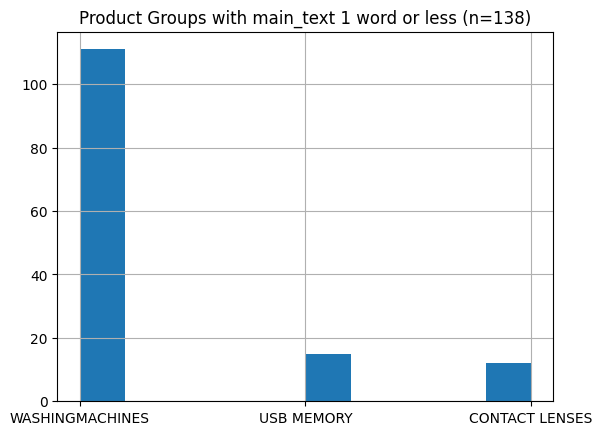

In [9]:
# categories with shortest descriptions?
tmp = dataset.productgroup[dataset.main_text.str.split(' ').str.len() < 2]
tmp.hist()
plt.title(f'Product Groups with main_text 1 word or less (n={len(tmp)})')
plt.show()

### Data Decisions
* Since this becomes inevitably a NLP problem, and all columns have informative features, it makes sense to combine all features for the text classification task.
* We clean each feature separately, and truncate them individually, we generate a good dataset to work on later
* Since these descriptions do not have a strong semantic sense, we can ignore the 'sequential' aspect of this text dataset, if required, and consider them as just a collection of words

## Data Processing

We first do some basic cleaning on each feature column individually, and then combine them to form the input to our model. 

Make sure that the different columns are not mixed by using the appropriate padding.

In [58]:
import re

def clean(x):
    x = x.replace('-', ' ').replace('_', ' ').replace('/', ' ')
    return re.sub(r'\b[0-9]+\b\s*', '', x)  # remove words that are just numbers

# truncate string
def truncate(x, max_len, pad='[UNK]'):
    if x and not pd.isnull(x):
        trunc = ' '.join(clean(x).split(' ')[:max_len])
        return trunc.strip()
    return ' '.join([pad] * max_len).strip()

dataset['main_text_cl'] = dataset['main_text'].apply(lambda x: truncate(x, 20))
dataset['add_text_cl'] = dataset['add_text'].apply(lambda x: truncate(x, 2))
dataset['manufacturer_cl'] = dataset['manufacturer'].apply(lambda x: truncate(x, 1))

In [59]:
# prepare and clean dataset
dataset['input_text'] = dataset.manufacturer_cl + ' ' + dataset.add_text_cl + ' ' + dataset.main_text_cl
dataset['input_text'] = dataset.input_text.str.strip()
dataset['input_text'] = dataset.input_text.replace('', np.nan)

# remove NAs in input text
dataset = dataset[~dataset.input_text.isna()]

### Embeddings

Since these text descriptions have English & German predominantly, we can use a pretrained 
multi-lingual model to generate the embeddings.
In this case, we use BERTEncoder from huggingface and generate 768-dimensional embeddings for each word.

BERT embeddings are rich and using this allows us to not have to build a complex model for classification later.

(A sample is shown below)

In [62]:
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertModel.from_pretrained('bert-base-multilingual-uncased')

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# tokenize and embed!
sample_text = dataset.input_text[15]

enc_input = tokenizer(sample_text, return_tensors='pt', padding='max_length', truncation=True, max_length=25)
output = model(**enc_input)

print('Sample Text:', sample_text)
print('Embedded Shape:', output.last_hidden_state.detach().numpy().shape)

Sample Text: VERBATIM USB STICKS VERBATIM STORE 'N' GO V3 16GB USB .STICK
Embedded Shape: (1, 23, 768)


### Visualize Embeddings

We can make a quick t-SNE plot to coarse understand how close and intertwined the embeddings are. t-SNE builds a force-directed graph which maintains local distances more than global distances.

We can see that the products have some distinctions between them (especially `USB MEMORY` category). The remaining are still somewhat separable, but not so much in 2 dimensions.

/home/ashwin/miniconda3/envs/clfenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


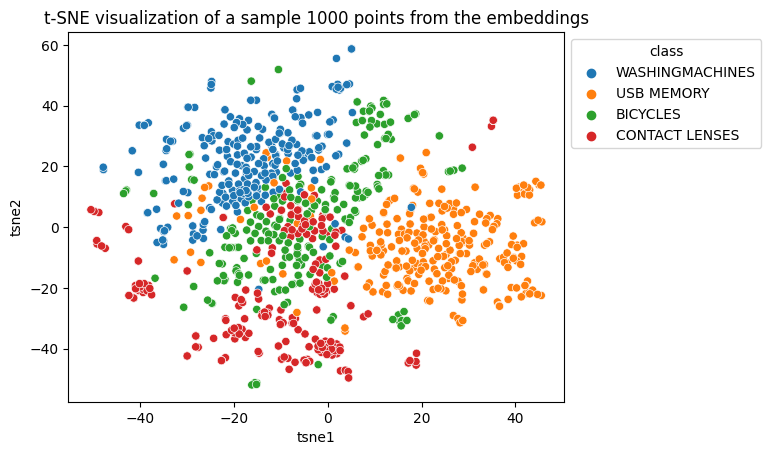

In [9]:
# load pre-computed embeddings from the dataset (from generate_embeddings.py)
X = np.load('./X.npy')
y = np.load('./y.npy')

sample_X, sample_y = X[:1000].reshape(1000, -1), y[:1000]

# t-SNE of word embeddings to see where they stand for each category
tsne = TSNE(learning_rate='auto', init='pca', random_state=1)
comps = tsne.fit_transform(sample_X)

plotdata = pd.DataFrame(comps, columns=['tsne1', 'tsne2'])
plotdata['class'] = encoder.inverse_transform(sample_y)

fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(data=plotdata, x='tsne1', y='tsne2', hue='class', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title('t-SNE visualization of a sample 1000 points from the embeddings')
plt.show()

## Modeling

We build a text classification model based on the BERT embedding. 
For this problem, we will use a simple Support Vector Classifier from scikit-learn for now. 

**NOTE:** The choice of a kernel-based method is important here, since they do not suffer from *curse of dimensionality*, which most other classical methods go through.

The rest of the model building procedure is mostly the standard practice:
1. Split the dataset into training, validation and test
2. Build the SVM on the training set, optimize performance on the valiation set.
3. Evaluate performance on the test set.

In [29]:
from sklearn.svm import SVC
import sklearn.metrics as skmetrics
from sklearn.model_selection import train_test_split, cross_validate
import pickle
import os

In [78]:
# load pre-computed embeddings from the dataset for reference
X = np.load(os.path.join(datadir, 'X.npy'))
y = np.load(os.path.join(datadir, 'y.npy'))

In [79]:
# flatten the input for SVM
X = X.reshape(X.shape[0], -1)

# split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=1, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, 
                                                      random_state=1, stratify=y_train)

In [23]:
svc = SVC(kernel='rbf', C=10.0)

# fit model
svc.fit(X_train, y_train)

## Model Analysis

In [74]:
# load model generated by train_model.py
with open(os.path.join(savedir, 'category_classifier.pkl'), 'rb') as f:
    svc = pickle.load(f)

### Validation Performance

The SVM model achieves an overall accuracy of **99.7%** on the validation set. 

* The model performs consistently well on all classes. 
* Need to verify the model for over-fitting

In [87]:
# evaluate performance on validation set
# y_hat = svc.predict(X_valid)

print('------------------------------')
print('--  Validation Performance  --')
print('------------------------------')
print(skmetrics.classification_report(y_pred=y_hat, y_true=y_valid, 
                                      target_names=encoder.classes_))
print(f'Accuracy: {skmetrics.accuracy_score(y_pred=y_hat, y_true=y_valid):.4f}')

------------------------------
--  Validation Performance  --
------------------------------
                 precision    recall  f1-score   support

       BICYCLES       1.00      1.00      1.00       320
 CONTACT LENSES       0.99      1.00      1.00       320
     USB MEMORY       1.00      1.00      1.00       320
WASHINGMACHINES       1.00      1.00      1.00       320

       accuracy                           1.00      1280
      macro avg       1.00      1.00      1.00      1280
   weighted avg       1.00      1.00      1.00      1280

Accuracy: 0.9977


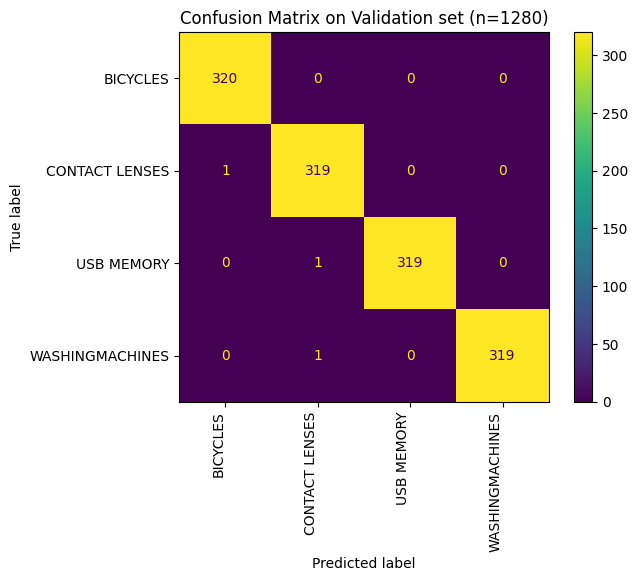

In [82]:
cm = skmetrics.confusion_matrix(y_pred=y_hat, y_true=y_valid)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot()
plt.title(f'Confusion Matrix on Validation set (n={len(y_valid)})')
plt.xticks(rotation=90, ha='right')
plt.show()

### Test Performance

In [86]:
# evaluate performance on test set
y_pred = svc.predict(X_test)

print('-----------------------------')
print('--    Test Performance     --')
print('-----------------------------')
print(skmetrics.classification_report(y_pred=y_pred, y_true=y_test, 
                                      target_names=encoder.classes_))
print(f'Accuracy: {skmetrics.accuracy_score(y_pred=y_pred, y_true=y_test):.4f}')

-----------------------------
--    Test Performance     --
-----------------------------
                 precision    recall  f1-score   support

       BICYCLES       0.99      1.00      1.00       400
 CONTACT LENSES       1.00      1.00      1.00       400
     USB MEMORY       1.00      0.99      1.00       400
WASHINGMACHINES       0.99      0.99      0.99       400

       accuracy                           1.00      1600
      macro avg       1.00      1.00      1.00      1600
   weighted avg       1.00      1.00      1.00      1600

Accuracy: 0.9969


## Improvements

While this has been a simple approach to text classification, this approach could be improved in many directions:

**Modeling**
* Using K-fold cross validation and combining the K models to form an ensemble would lead to more robust results, with better uncertainty estimation. This is especially useful to analyze results post-deployment
* Although there is not much room for improvement with model performance itself, using a Transformer instead of SVMs allows for more generalization. It can also utilize the sequence information better. More importantly, a transformer offers a scalable alternative as SVMs scale poorly with number of samples and improves inference times.

**Data Processing**
* Some smarter feature engineering could be used to reduce the model complexity.
* Currently, we use a BERT Encoder, which may seem an overkill for this current task with its 768-dimensional embeddings.
* Better preprocessing and cleaning the data to deal with product IDs and unintelligible words from the descriptions can contribute to improving the modeling pipeline.